# Mount Drive and Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import re
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.linear_model import LogisticRegression
from sklearn import ensemble 
from sklearn.metrics import confusion_matrix 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score

from sklearn.pipeline import Pipeline

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Exploratory Data Analysis

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/ML_datasets/sarcastic dataset/Train.csv")
df_train.head()

,ID,comment,date,down,parent_comment,score,top,topic,user,label
0,uid_590555,"Well, let's be honest here, they don't actuall...",2015-04,0,They should shut the fuck up and let the commu...,2,2,starcitizen,Combat_Wombatz,0
1,uid_671762,"Well, I didn't need evidence to believe in com...",2016-12,-1,You need evidence to kill people? I thought we...,6,-1,EnoughCommieSpam,starkadd,1
2,uid_519689,"Who does an ""official promo"" in 360p?",2013-11,0,2014 BMW S1000R: Official Promo,3,3,motorcycles,phybere,0
3,uid_788362,Grotto koth was the best,2015-09,0,Not really that memorable lol if you want memo...,2,2,hcfactions,m0xyMC,1
4,uid_299252,Neal's back baby,2015-11,0,James Neal hit on Zach Parise,-5,-5,hockey,Somuch101,1


In [ ]:
df_train.shape

(15000, 10)

Since, many fields are irrelevant to our NLP objective, we will drop them

In [ ]:
df_train.drop(['ID', 'date', 'down', 'score', 'top'], axis=1, inplace=True)
df_train.head()

,comment,parent_comment,topic,user,label
0,"Well, let's be honest here, they don't actuall...",They should shut the fuck up and let the commu...,starcitizen,Combat_Wombatz,0
1,"Well, I didn't need evidence to believe in com...",You need evidence to kill people? I thought we...,EnoughCommieSpam,starkadd,1
2,"Who does an ""official promo"" in 360p?",2014 BMW S1000R: Official Promo,motorcycles,phybere,0
3,Grotto koth was the best,Not really that memorable lol if you want memo...,hcfactions,m0xyMC,1
4,Neal's back baby,James Neal hit on Zach Parise,hockey,Somuch101,1


Let's see some sample comments!

In [ ]:
df_train.iloc[0]['comment']

"Well, let's be honest here, they don't actually seem to do much moderating, so they have to spend their time doing *something*."

In [ ]:
df_train.iloc[1]['comment']

"Well, I didn't need evidence to believe in communism."

In [ ]:
# See distribution count of labels
df_train['label'].value_counts()

1    7527
0    7473
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Sarcasm vs Non-sarcasm')

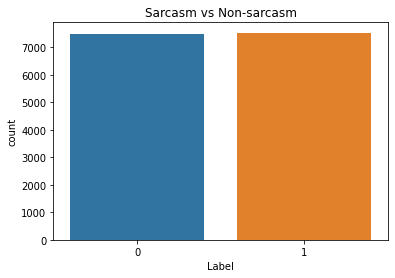

In [ ]:
sns.countplot(df_train.label)
plt.xlabel('Label')
plt.title('Sarcasm vs Non-sarcasm')

Let's see what are the most frequent words used in scarcastic comments!

In [ ]:
wordcloud = WordCloud(background_color='black', stopwords = stopwords.words('english'),
                max_words = 200, max_font_size = 100, 
                random_state = 17, width=800, height=400)

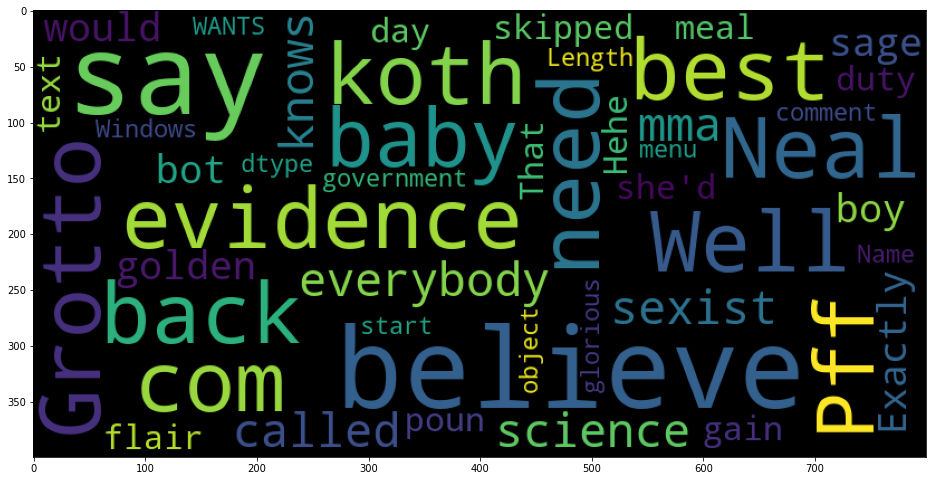

In [ ]:
plt.figure(figsize=(16, 12))
wordcloud.generate(str(df_train.loc[df_train['label'] == 1, 'comment']))
plt.imshow(wordcloud);

Let's experiment if scarcastic comments are more active in any specific topic?!

In [ ]:
df_topics = df_train.loc[df_train['label'] == 1]
df_topics_grouped = df_topics.groupby('topic').size().sort_values(ascending=False)
df_topics_grouped[:5]

topic
AskReddit          371
politics           357
worldnews          268
leagueoflegends    195
news               153
dtype: int64

As we can see, Reddit, Politics and World News has more scarcastic comments! But why these?

In [ ]:
df_train['topic'].value_counts(normalize=True)[:5]

AskReddit          0.062800
politics           0.038133
worldnews          0.026600
leagueoflegends    0.022067
funny              0.019067
Name: topic, dtype: float64

The answer to above question is, we have most of data realted to AskReddit, Politics and World News. Thus, it could be common to see more scarcastic comments related to these topics. 

In [ ]:
# Top 5 scarcastic users! ;)
df_scarcastic_users = df_topics.groupby('user').size().sort_values(ascending=False)
df_scarcastic_users[:5]

user
Biffingston       11
NeonDisease        5
Gamer_152          4
JumpingJazzJam     4
Roddy0608          3
dtype: int64

# Text Preprocessing

In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
def text_preprocessing_fn(text):
    """
    Cleaning and parsing the text.

    """
    #Adding custom stopwords
    stopwords_custom = nltk.corpus.stopwords.words('english')
    newStopWords = ['uh,','uh','yeah','yeah,','um','um,','oh', 'uh-huh', 'uhhuh', "theyre","dont",'huhuh']
    stopwords_custom.extend(newStopWords)

    #Text preprocessing
    text_cleaned = clean_text(text)

    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    tokens = tokenizer.tokenize(text_cleaned)

    remove_stopwords = [w for w in tokens if w not in stopwords_custom and len(w) > 2]

    #Stemming
    #stemmer = nltk.stem.PorterStemmer()
    #processed_text = " ".join(stemmer.stem(token) for token in remove_stopwords)

    #Lemmatization
    lemmatizer = nltk.stem.WordNetLemmatizer()
    processed_text = " ".join(lemmatizer.lemmatize(token, pos='v') for token in remove_stopwords)
    
    combined_text = ''.join(processed_text)
    return combined_text

In [ ]:
df_train['comments_preprocessed'] = df_train['comment'].apply(text_preprocessing_fn)
df_train.head(2)

,comment,parent_comment,topic,user,label,comments_preprocessed
0,"Well, let's be honest here, they don't actuall...",They should shut the fuck up and let the commu...,starcitizen,Combat_Wombatz,0,well let honest actually seem much moderate sp...
1,"Well, I didn't need evidence to believe in com...",You need evidence to kill people? I thought we...,EnoughCommieSpam,starkadd,1,well didnt need evidence believe communism


# Model building and experiments



In [ ]:
sentences = df_train[['comments_preprocessed']].values
y = df_train['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
vectorizer.fit(sentences_train.ravel())

X_train = vectorizer.fit_transform(sentences_train.ravel())
X_test  = vectorizer.transform(sentences_test.ravel())

In [ ]:
logit = LogisticRegression(C=1, n_jobs=4, solver='lbfgs', 
                           random_state=17, verbose=1)

In [ ]:
logit.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.7s finished


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=4, penalty='l2', random_state=17,
                   solver='lbfgs', tol=0.0001, verbose=1, warm_start=False)

In [ ]:
predictions = logit.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.63      0.65      0.64      1904
           1       0.63      0.60      0.62      1846

    accuracy                           0.63      3750
   macro avg       0.63      0.63      0.63      3750
weighted avg       0.63      0.63      0.63      3750



In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print("True Negatives : ", tn)
print("True Positives : ", tp)

print("False Negatives : ", fn)
print("False Positives : ", fp)

True Negatives :  1238
True Positives :  1116
False Negatives :  730
False Positives :  666


In [ ]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.63      0.67      0.65      1904
           1       0.64      0.59      0.61      1846

    accuracy                           0.63      3750
   macro avg       0.63      0.63      0.63      3750
weighted avg       0.63      0.63      0.63      3750



In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print("True Negatives : ", tn)
print("True Positives : ", tp)

print("False Negatives : ", fn)
print("False Positives : ", fp)

True Negatives :  1275
True Positives :  1095
False Negatives :  751
False Positives :  629
